In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
data = pd.read_csv("train_v9rqX0R.csv")

In [3]:
test = pd.read_csv("test_AbJTz2l.csv")

In [4]:

data['Outlet_Age'] = 2025 - data['Outlet_Establishment_Year']
test['Outlet_Age'] = 2025 - test['Outlet_Establishment_Year']


max_visibility = data['Item_Visibility'].max()
data['Item_Visibility_Scaled'] = data['Item_Visibility'] / max_visibility
test['Item_Visibility_Scaled'] = test['Item_Visibility'] / max_visibility

data['Low_Visibility'] = (data['Item_Visibility'] < 0.05).astype(int)
test['Low_Visibility'] = (test['Item_Visibility'] < 0.05).astype(int)


def simplify_item_type(x):
    if x in ['Dairy', 'Meat', 'Fruits and Vegetables', 'Snack Foods', 'Frozen Foods', 'Breakfast', 'Baking Goods', 'Canned', 'Starchy Foods']:
        return 'Food'
    elif x in ['Household', 'Health and Hygiene', 'Others']:
        return 'Non-Consumable'
    else:
        return 'Drinks'

data['Item_Category'] = data['Item_Type'].apply(simplify_item_type)
test['Item_Category'] = test['Item_Type'].apply(simplify_item_type)

def price_band(x):
    if x < 70:
        return 'Low'
    elif x < 150:
        return 'Medium'
    elif x < 250:
        return 'High'
    else:
        return 'Very High'

data['Item_MRP_Band'] = data['Item_MRP'].apply(price_band)
test['Item_MRP_Band'] = test['Item_MRP'].apply(price_band)


data.loc[data['Item_Category'] == 'Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'
test.loc[test['Item_Category'] == 'Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'

In [5]:

data['Item_Weight'].fillna(data['Item_Weight'].mean(), inplace=True)


data['Outlet_Size'] = data['Outlet_Size'].fillna('Unknown')


data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({
    'LF': 'Low Fat',
    'low fat': 'Low Fat',
    'reg': 'Regular'
})

In [6]:
test['Outlet_Size'] = test['Outlet_Size'].fillna('Unknown')
test['Item_Weight'] = test['Item_Weight'].fillna(data['Item_Weight'].mean())
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace({
    'LF': 'Low Fat',
    'low fat': 'Low Fat',
    'reg': 'Regular'
})

In [7]:
categorical_cols = ['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Category', 'Item_MRP_Band']

label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

In [8]:
drop_cols = ['Item_Identifier', 'Outlet_Identifier', 'Item_Type', 'Item_Visibility', 'Outlet_Establishment_Year']
X_train = data.drop(columns=drop_cols + ['Item_Outlet_Sales'])
y_train = data['Item_Outlet_Sales']

X_test = test.drop(columns=drop_cols)

In [9]:


model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=15)
model.fit(X_train, y_train)


train_preds = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
print(f"Training RMSE: {train_rmse}")


Training RMSE: 653.642376730938


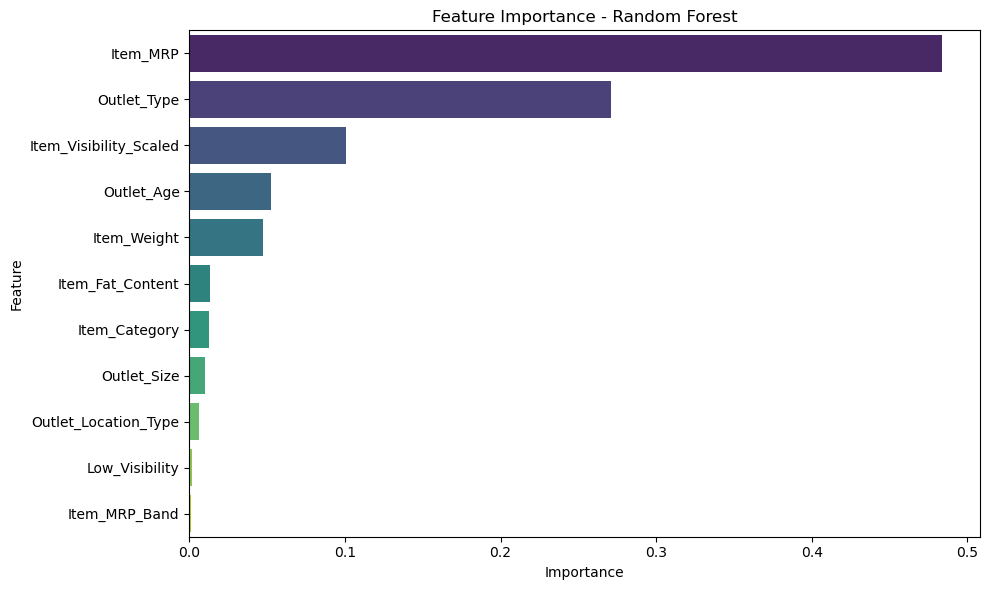

In [11]:
importances = model.feature_importances_


feature_names = X_train.columns


feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

In [10]:

test_preds = model.predict(X_test)


submission = test[['Item_Identifier', 'Outlet_Identifier']].copy()
submission['Item_Outlet_Sales'] = test_preds


submission.to_csv('submission_RF_FE.csv', index=False)